# Fetching model, testing and exporting it

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

In [4]:
original_image_cache = {}

def preprocess_image(image):
  image = np.array(image)
  # reshape into shape [batch_size, height, width, num_channels]
  img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  image = tf.image.convert_image_dtype(img_reshaped, tf.float32)
  return image

def load_image_from_url(img_url):
  """Returns an image with shape [1, height, width, num_channels]."""
  user_agent = {'User-agent': 'Colab Sample (https://tensorflow.org)'}
  response = requests.get(img_url, headers=user_agent)
  image = Image.open(BytesIO(response.content))
  image = preprocess_image(image)
  return image

def load_image_from_file(image_file):
  image = Image.open(image_file)
  image = preprocess_image(image)
  return image

img_rm = load_image_from_url('https://upload.wikimedia.org/wikipedia/commons/f/f7/Honey_comb.jpg')
img_file = load_image_from_file('Honey_comb.jpg')

def load_image(image_url, image_size=256, dynamic_size=False, max_dynamic_size=512):
  """Loads and preprocesses images."""
  # Cache image file locally.
  if image_url in original_image_cache:
    img = original_image_cache[image_url]
  elif image_url.startswith('https://'):
    img = load_image_from_url(image_url)
  else:
    fd = tf.io.gfile.GFile(image_url, 'rb')
    img = preprocess_image(Image.open(fd))
  original_image_cache[image_url] = img
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img_raw = img
  if tf.reduce_max(img) > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  if not dynamic_size:
    img = tf.image.resize_with_pad(img, image_size, image_size)
  elif img.shape[1] > max_dynamic_size or img.shape[2] > max_dynamic_size:
    img = tf.image.resize_with_pad(img, max_dynamic_size, max_dynamic_size)
  return img, img_raw

# TODO: my new function
def load_images_into_batch(image_urls, image_size=256, dynamic_size=False, max_dynamic_size=512):
  img_batch = None
  
  for image_url in image_urls:
    if img_batch is None:
      # handling first image in the batch
      img_batch, _ = load_image(image_url, image_size=256, dynamic_size=False, max_dynamic_size=512)
      continue
    # 2nd and onward images in the batch
    img, _ = load_image(image_url, image_size=256, dynamic_size=False, max_dynamic_size=512)
    img_batch = tf.concat([img_batch, img], 0)
  
  return img_batch

def show_image(image, title=''):
  image_size = image.shape[1]
  w = (image_size * 6) // 320
  plt.figure(figsize=(w, w))
  plt.imshow(image[0], aspect='equal')
  plt.axis('off')
  plt.title(title)
  plt.show()

In [11]:
dynamic_size = False

model_name = "efficientnetv2-s"
model_handle = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2"
image_size = 384

print(f"Selected model: {model_name} : {model_handle}")


max_dynamic_size = 512
#if model_name in model_image_size_map:
#  image_size = model_image_size_map[model_name]
#  dynamic_size = False
#  print(f"Images will be converted to {image_size}x{image_size}")
#else:
#  dynamic_size = True
#  print(f"Images will be capped to a max size of {max_dynamic_size}x{max_dynamic_size}")

labels_file = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"

#download labels and creates a maps
downloaded_file = tf.keras.utils.get_file("labels.txt", origin=labels_file)

classes = []

with open(downloaded_file) as f:
  labels = f.readlines()
  classes = [l.strip() for l in labels]

Selected model: efficientnetv2-s : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2


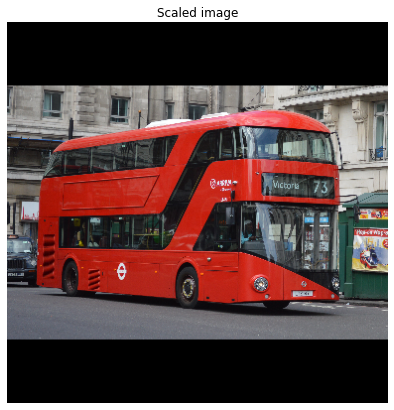

In [12]:
image_name = "bus" # @param ['tiger', 'bus', 'car', 'cat', 'dog', 'apple', 'banana', 'turtle', 'flamingo', 'piano', 'honeycomb', 'teapot']

images_for_test_map = {
    "tiger": "https://upload.wikimedia.org/wikipedia/commons/b/b0/Bengal_tiger_%28Panthera_tigris_tigris%29_female_3_crop.jpg",
    #by Charles James Sharp, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, via Wikimedia Commons
    "bus": "https://upload.wikimedia.org/wikipedia/commons/6/63/LT_471_%28LTZ_1471%29_Arriva_London_New_Routemaster_%2819522859218%29.jpg",
    #by Martin49 from London, England, CC BY 2.0 <https://creativecommons.org/licenses/by/2.0>, via Wikimedia Commons
    "car": "https://upload.wikimedia.org/wikipedia/commons/4/49/2013-2016_Toyota_Corolla_%28ZRE172R%29_SX_sedan_%282018-09-17%29_01.jpg",
    #by EurovisionNim, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, via Wikimedia Commons
    "cat": "https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_November_2010-1a.jpg",
    #by Alvesgaspar, CC BY-SA 3.0 <https://creativecommons.org/licenses/by-sa/3.0>, via Wikimedia Commons
    "dog": "https://upload.wikimedia.org/wikipedia/commons/archive/a/a9/20090914031557%21Saluki_dog_breed.jpg",
    #by Craig Pemberton, CC BY-SA 3.0 <https://creativecommons.org/licenses/by-sa/3.0>, via Wikimedia Commons
    "apple": "https://upload.wikimedia.org/wikipedia/commons/1/15/Red_Apple.jpg",
    #by Abhijit Tembhekar from Mumbai, India, CC BY 2.0 <https://creativecommons.org/licenses/by/2.0>, via Wikimedia Commons
    "banana": "https://upload.wikimedia.org/wikipedia/commons/1/1c/Bananas_white_background.jpg",
    #by fir0002  flagstaffotos [at] gmail.com       Canon 20D + Tamron 28-75mm f/2.8, GFDL 1.2 <http://www.gnu.org/licenses/old-licenses/fdl-1.2.html>, via Wikimedia Commons
    "turtle": "https://upload.wikimedia.org/wikipedia/commons/8/80/Turtle_golfina_escobilla_oaxaca_mexico_claudio_giovenzana_2010.jpg",
    #by Claudio Giovenzana, CC BY-SA 3.0 <https://creativecommons.org/licenses/by-sa/3.0>, via Wikimedia Commons
    "flamingo": "https://upload.wikimedia.org/wikipedia/commons/b/b8/James_Flamingos_MC.jpg",
    #by Christian Mehlführer, User:Chmehl, CC BY 3.0 <https://creativecommons.org/licenses/by/3.0>, via Wikimedia Commons
    "piano": "https://upload.wikimedia.org/wikipedia/commons/d/da/Steinway_%26_Sons_upright_piano%2C_model_K-132%2C_manufactured_at_Steinway%27s_factory_in_Hamburg%2C_Germany.png",
    #by "Photo: © Copyright Steinway & Sons", CC BY-SA 3.0 <https://creativecommons.org/licenses/by-sa/3.0>, via Wikimedia Commons
    "honeycomb": "https://upload.wikimedia.org/wikipedia/commons/f/f7/Honey_comb.jpg",
    #by Merdal, CC BY-SA 3.0 <http://creativecommons.org/licenses/by-sa/3.0/>, via Wikimedia Commons
    "teapot": "https://upload.wikimedia.org/wikipedia/commons/4/44/Black_tea_pot_cropped.jpg",
    #by Mendhak, CC BY-SA 2.0 <https://creativecommons.org/licenses/by-sa/2.0>, via Wikimedia Commons
}

img_url = images_for_test_map[image_name]
image, original_image = load_image(img_url, image_size, dynamic_size, max_dynamic_size)
show_image(image, 'Scaled image')

In [16]:
classifier = hub.load(model_handle)

input_shape = image.shape
warmup_input = tf.random.uniform(input_shape, 0, 1.0)
%time warmup_logits = classifier(warmup_input).numpy()

https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/classification/2
CPU times: user 2.81 s, sys: 421 ms, total: 3.23 s
Wall time: 2.08 s


CPU times: user 1.01 s, sys: 350 ms, total: 1.36 s
Wall time: 233 ms
(1)  875 - trolleybus: 0.6026712656021118
(2)  706 - passenger car: 0.20901674032211304
(3)  655 - minibus: 0.030008427798748016
(4)  780 - school bus: 0.006755315698683262
(5)  830 - streetcar: 0.005978232249617577


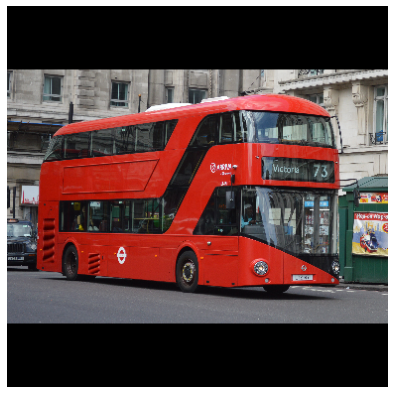

In [17]:
# Run model on image
%time probabilities = tf.nn.softmax(classifier(image)).numpy()

top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()
np_classes = np.array(classes)

# Some models include an additional 'background' class in the predictions, so
# we must account for this when reading the class labels.
includes_background_class = probabilities.shape[1] == 1001

for i, item in enumerate(top_5):
  class_index = item if includes_background_class else item + 1
  line = f'({i+1}) {class_index:4} - {classes[class_index]}: {probabilities[0][top_5][i]}'
  print(line)

show_image(image, '')

# Create Inference script

In [18]:
! pygmentize 1_src/inference.py

from PIL import Image
import io
import base64
import json

import numpy as np
import tensorflow as tf
from io import BytesIO
import os

import requests
import sys

# Imports for GRPC invoke on TFS
import grpc
from tensorflow.compat.v1 import make_tensor_proto
from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc


HEIGHT = os.getenv("IMAGE_HEIGHT", 224)
WIDTH = os.getenv("IMAGE_WIDTH", 224)
MAX_GRPC_MESSAGE_LENGTH = 512 * 1024 * 1024
USE_GRPC = True if os.getenv("USE_GRPC").lower() == "true" else False

# Restrict memory growth on GPU's
physical_gpus = tf.config.experimental.list_physical_devices("GPU")
if physical_gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in physical_gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(physical_gpus), "Physical GPUs,", len(logical_

In [19]:
! pygmentize 1_src/requirements.txt

numpy
Pillow
tensorflow


# Packaging model artifacts

In [20]:
import os

model_dir = f"./{model_name}/1"
code_dir = f"./{model_name}/code"
os.makedirs(model_dir, exist_ok=False)
os.makedirs(code_dir, exist_ok=False)
tf.saved_model.save(classifier, model_dir)

INFO:tensorflow:Assets written to: ./efficientnetv2-s/1/assets


INFO:tensorflow:Assets written to: ./efficientnetv2-s/1/assets


In [24]:
! cp 1_src/inference.py $code_dir
! cp 1_src/requirements.txt $code_dir
!tar -C "$PWD" -czf model.tar.gz  efficientnetv2-s/

In [22]:
import sagemaker
from sagemaker.tensorflow import TensorFlowModel


import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
#role = get_execution_role() 
role="arn:aws:iam::941656036254:role/service-role/AmazonSageMaker-ExecutionRole-20210904T193230" # TODO: this has to be replaced

bucket = sagemaker_session.default_bucket()
prefix = 'tf-serving-2' # TODO: switch  to 'tf-serving' once testing is done
s3_path = 's3://{}/{}'.format(bucket, prefix)


In [26]:

model_data = sagemaker_session.upload_data('model.tar.gz',
                                           bucket,
                                           os.path.join(prefix, 'model'))

In [35]:
env = {"SAGEMAKER_GUNICORN_LOGLEVEL":"debug",
       "SAGEMAKER_TFS_ENABLE_BATCHING":"true",
       "SAGEMAKER_TFS_MAX_BATCH_SIZE":"4",
       "SAGEMAKER_TFS_BATCH_TIMEOUT_MICROS":"100000",
       "SAGEMAKER_TFS_NUM_BATCH_THREADS":"6",
       "SAGEMAKER_TFS_MAX_ENQUEUED_BATCHES":"6",
       "USE_GRPC":"true"
       }

# The "Model" object doesn't create a SageMaker Model until a Transform Job or Endpoint is created.
tensorflow_serving_model = TensorFlowModel(model_data=model_data,
                                 name="efficientnetv2-1",
                                 role=role,
                                 framework_version='2.8',
                                 env=env,
                                 sagemaker_session=sagemaker_session)

In [36]:
predictor = tensorflow_serving_model.deploy(initial_instance_count=1, instance_type='ml.g4dn.xlarge')

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


---------!

In [31]:
response_remote = predictor.predict(image.numpy())

In [32]:
probabilities = np.array(response_remote['predictions'])

top_5 = tf.argsort(probabilities, axis=-1, direction="DESCENDING")[0][:5].numpy()
np_classes = np.array(classes)

# Some models include an additional 'background' class in the predictions, so
# we must account for this when reading the class labels.
includes_background_class = probabilities.shape[1] == 1001

for i, item in enumerate(top_5):
  class_index = item if includes_background_class else item + 1
  line = f'({i+1}) {class_index:4} - {classes[class_index]}: {probabilities[0][top_5][i]}'
  print(line)


(1)  875 - trolleybus: 8.50741577
(2)  706 - passenger car: 7.44844818
(3)  655 - minibus: 5.50750923
(4)  780 - school bus: 4.01636744
(5)  830 - streetcar: 3.89416456


In [37]:
predictor.delete_endpoint()